In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_str_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
print(patterns[0].shape)

(1, 4, 3000)


In [4]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')
# d2 = Population(N=N[2], tau=1e-2, phi=phi, name='d2')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
synapse = LinearSynapse(J[0][1].K, 6.5)
# J[0][1].update_sequences(patterns[0][0][1], patterns[1][0][2], synapse.h_EE, plasticity.f, plasticity.g)
# J[0][1].update_sequences(patterns[0][0][0], patterns[1][0][1], synapse.h_EE, plasticity.f, plasticity.g)
network = RateNetwork([ctx, d1], J, formulation=4, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


### Simulation

In [5]:
init_inputs = [np.zeros(ctx.size),
               np.zeros(d1.size)]
input_patterns = [p[0] for p in patterns]

T=5 #ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, input_patterns, plasticity, 
                          delta_t=300, eta=0.03, tau_e=150, lamb=0.9, 
                          noise=[0.13,0.13,0.13], e_bl = [0.06,0.01,0.04,0.07], 
                          alpha=0.9, gamma=1, adap=0, env=2, etrace=False,  
                          r_ext=[lambda t:0, lambda t: .5], print_output=True)

INFO:network:Integrating network dynamics
  1%|▏         | 70/4999 [00:03<01:48, 45.55it/s] 

null-->scavenge


 10%|▉         | 487/4999 [00:05<00:24, 187.28it/s]

scavenge-->aim


 17%|█▋        | 832/4999 [00:07<00:23, 179.30it/s]

aim-->reach


 21%|██        | 1062/4999 [00:08<00:20, 189.18it/s]

reach-->lick
Mouse retrieved water


 29%|██▉       | 1469/4999 [00:10<00:20, 169.30it/s]

lick-->scavenge


 48%|████▊     | 2414/4999 [00:16<00:13, 186.30it/s]

scavenge-->aim


 56%|█████▌    | 2779/4999 [00:18<00:11, 188.22it/s]

aim-->reach


 60%|█████▉    | 2990/4999 [00:19<00:11, 173.89it/s]

reach-->lick
Mouse retrieved water


 67%|██████▋   | 3369/4999 [00:21<00:08, 187.58it/s]

lick-->scavenge


 78%|███████▊  | 3916/4999 [00:24<00:05, 183.14it/s]

scavenge-->aim


 86%|████████▌ | 4287/4999 [00:26<00:03, 187.46it/s]

aim-->reach


 90%|█████████ | 4520/4999 [00:27<00:02, 188.62it/s]

reach-->lick
Mouse retrieved water


 97%|█████████▋| 4872/4999 [00:29<00:00, 190.66it/s]

lick-->scavenge


100%|██████████| 4999/4999 [00:29<00:00, 166.68it/s]


### Results

In [6]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.pops[2])
# filename = 'learning-0005-1600-600-5-1000-v0'
# np.savez('./data/' + filename + '.npz', 
#          overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg, 
#          correlations_ctx=correlations_ctx, correlations_bg=correlations_bg, 
#          state_ctx=net_ctx.exc.state, state_bg=net_bg.exc.state)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 88.26it/s]
INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 127.73it/s]


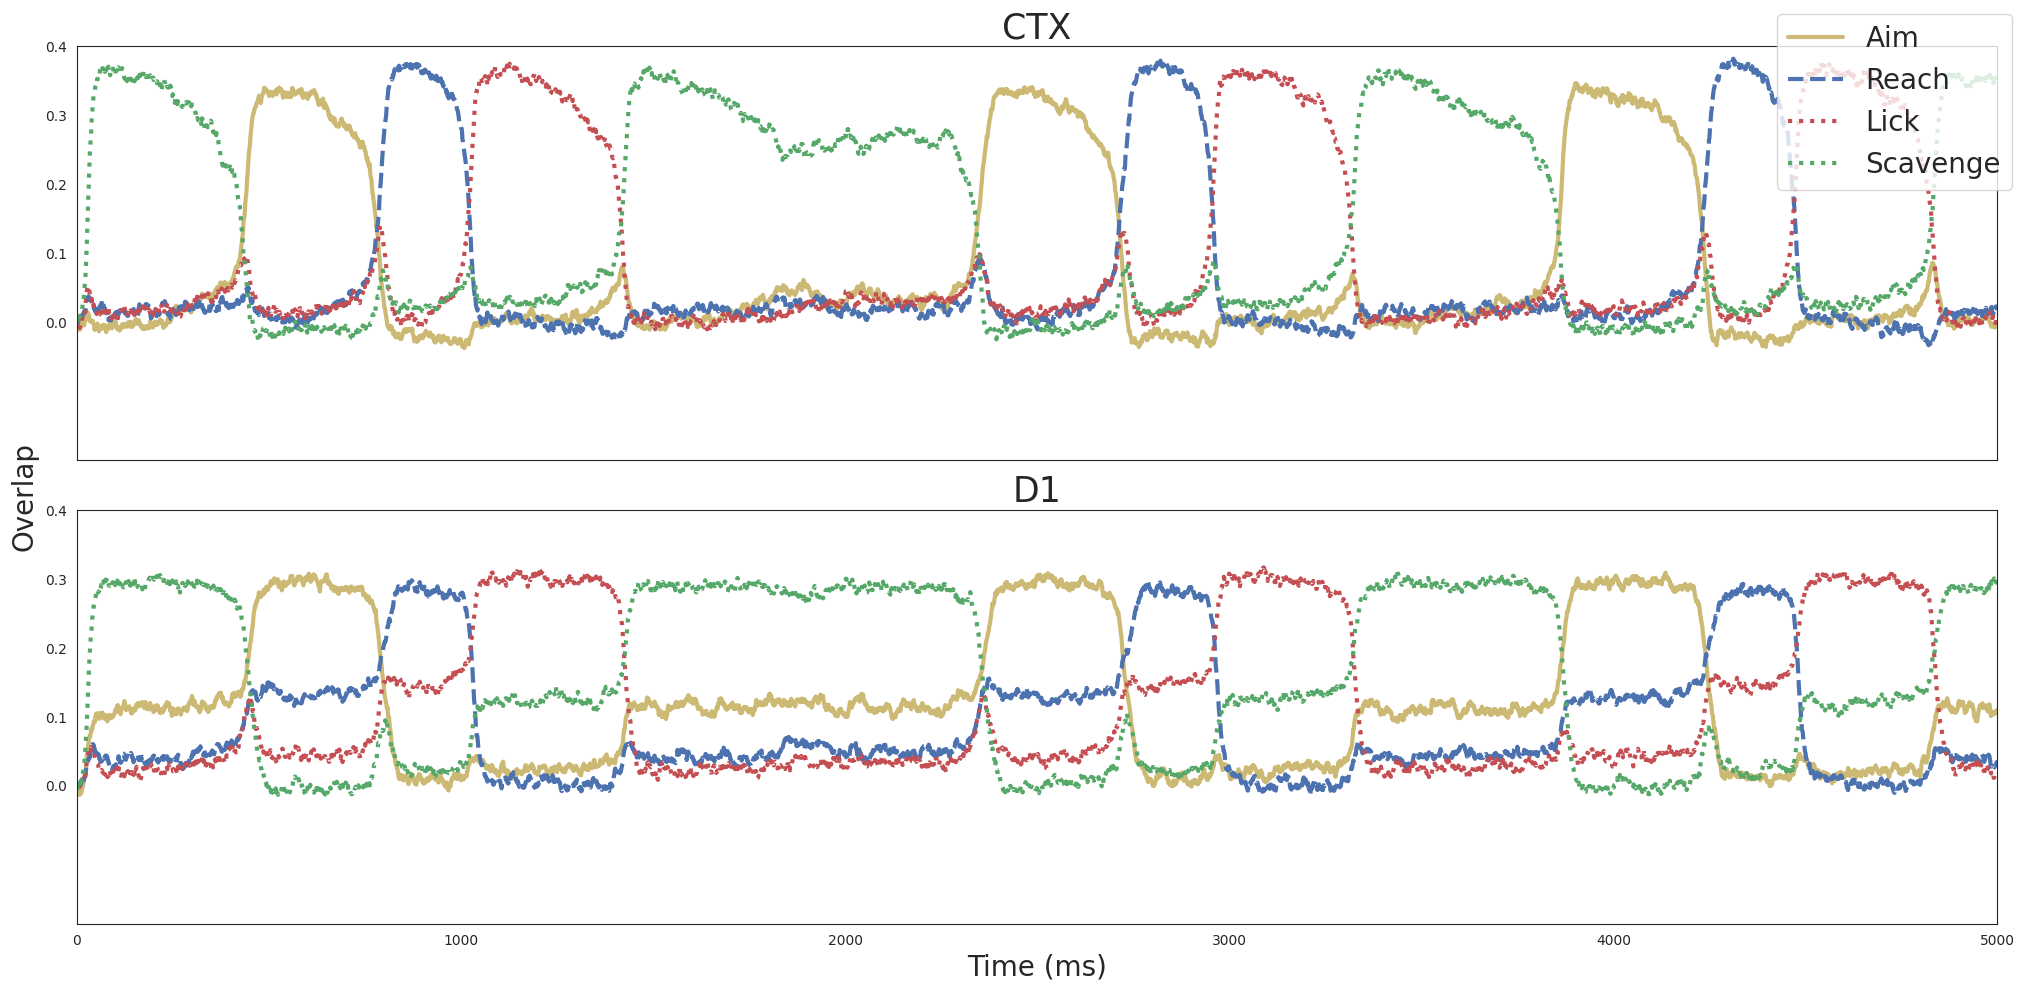

In [7]:
sns.set_style('white') 
colors = sns.color_palette('deep')

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(20,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
# axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 5000))
plt.setp(axes, ylim=(-.2, .4))
plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/simulation-env-pre-learning.jpg', bbox_inches = "tight", format='jpg')

plt.show()


In [8]:
def temporal_diff(A, B, max_iter):
    sum = 0
    cnt = 0
    for i in range(len(A)):
        if i == 0: continue
        if B[i+1] == None:
            break
        diff = B[i+1][1] - A[i][1]
        sum += (diff)
        cnt += 1
    return sum / cnt

temporal_diff(mouse.behaviors[0], mouse.behaviors[1], 100)

1155.2222222222222